# References

Credit: codes developed in this project inspired by the following references:

\[2\] https://www.tensorflow.org/tutorials/keras/classification

\[3\] https://medium.com/analytics-vidhya/artificial-neural-network-ann-with-keras-simplified-use-case-if-student-pass-the-exam-code-949ddb2a9c91

\[4\] https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

# Packages

This tutorial uses [tensorflow.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train neural networks (NN). The developed NN is used to classify images of handwritten digits from 0 to 9 in the MNIST dataset. The required packages are imported below:

In [0]:
# pyplot to plot figures
import matplotlib.pyplot as plt
# numpy for algebraic operations on arrays
import numpy as np
# tensorflow API as tf
import tensorflow as tf
# tf.keras API for NN
from tensorflow import keras
# plot_model to visualize the built NN
from tensorflow.keras.utils import plot_model
# KerasClassifier to construct a NN model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# cross_val_score to evaluate NN model accuracy
# GridSearchCV to fine-tune NN model from a list of parameters
from sklearn.model_selection import cross_val_score, GridSearchCV


# Test 1: Loading data

This tutorial uses the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which fits multiple regression and classification techniques. The dataset contains images of handwritten digits \{0, 1, 2, ..., 9\}, each in a format of 28 by 28 pixels, with pixel values ranging from 0 to 255. The dataset also contains a label for each image; the label is an integer in \{0,1,2,...,9\}. The dataset contains 60,000 training images and 10,000 testing images of individual digits labeled according to 10 classes of labels \{0, 1, 2, ..., 9\}. The training images and labels allow training a neural network (NN) and the testing images and labels allow evaluating the network's accuracy in classifying previously unseen images. To import and load the MNIST dataset so it can be used in `tf.keras`, function `load_data` is used to load the dataset directly from `TensorFlow`, which returns 4 `NumPy` arrays: `X_train` images with `y_train` labels for the training set, and `X_test` images with `y_test` labels for the testing set. The dimension of these arrays are confirmed by the below code snippets, which show 60,000 elements in `X_train` (and `y_train`), and 10,000 in `X_test` (and `y_test`). The pixel values are scaled down from \[0,255\] range to the standardized \[0,1\] range, which is done by dividing over the max value of 255. An image of a digit before and after scaling is shown below to confirm the data was scaled.

K-fold cross-validation (CV) is used to test a regression or classification algorithm properly, and consists in splitting the training dataset into K-folds, training on K-1 of them and validating on the remaining fold, and switching the validation fold K times. The resulting mean error is a less-biased metric of the performance of the algorithm on the training dataset. To create cross-validation folds, a method from sklearn called `sklearn.model_selection.cross_val_score` is used to split the dataset, call the neural network constructor by argument `estimator`, specify the desired number of folds by argument `cv`, specify the training data and labels by arguments `X` and `y`, and finally perform cross-validation. Note that full descriptions of the neural network object `neurnet_classifier` and Keras constructor `KerasClassifier` will be discussed in the upcoming sections, as this section solely focuses on how to perform cross validation. The K-fold cross validation choose a number of folds `cv` equal to 5, which results in an accuracy for each run of the cross validation and a mean accuracy for the total cross validation such as shown by the below code.

In [2]:
# import mnist dataset from tf.keras
data = keras.datasets.mnist
# load mnist dataset into separate training images/labels and testing images/labels
(X_train,y_train),(X_test,y_test) = data.load_data()
# list the classes of labels, i.e. digits 0,1,2,3,4,5,6,7,8,9
classes = range(10)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# check the dimensions of each array:
# X_train: 60,000 images, each represented as 28 x 28 pixels
print('X_train dimensions:', X_train.shape)
# y_train: 60,000 labels
print('y_train elements:', len(y_train))
# X_test: 10,000 images, each represented as 28 x 28 pixels
print('X_test dimensions:', X_test.shape)
# y_test: 60,000 labels
print('y_test elements:', len(y_test))


X_train dimensions: (60000, 28, 28)
y_train elements: 60000
X_test dimensions: (10000, 28, 28)
y_test elements 10000


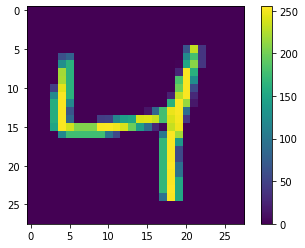

In [4]:
# plot a single image from X_train
# note that pixel values on the plot range from 0 to 255
plt.figure()
plt.imshow(X_train[2])
plt.colorbar()
plt.grid(False)
plt.show()

In [0]:
# scale data to [0,1] intervals by dividing each pixel value over 255
X_train = (1.0/255.0) * X_train
X_test  = (1.0/255.0) * X_test

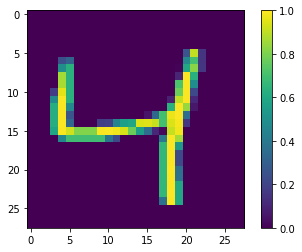

In [6]:
# plot a single image from X_train
# note that pixel values on the plot now range from 0 to 1
plt.figure()
plt.imshow(X_train[2])
plt.colorbar()
plt.grid(False)
plt.show()

In [7]:
# Showing how to create cross-validation folds,
# so that the algorithm can be tested properly
#
def neurnet_classifier():
    # create model with each input being flattened
    # sequential model is used to indicate the model has a linear stack of layers
    # flatten is used to flatten the 28x28 input to 1x784 input
    # dense layers are used to have fully interconnected neurons, allowing faster learning
    # the number of neurons at the output layer must be equal to the number of classes (10)
    # the relu activation function is chosen for the hidden layer because
    # it avoids the saturation of its gradient, thus accelerating the convergence of 
    # gradient descent compared to other activation functions such as sigmoid / tanh
    # the sigmoid activation function is chosen to smoothen the output to nearest
    # value of either 0 (image not in class) or 1 (image in class)
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
    ])
    # compile model that compares performance using accuracy as a metric, 
    # an optimizer based on the gradient descent algorithm such as adam, and 
    # a sparse categorical cross entropy which computes the crossentropy loss 
    # between the predictions and true labels, and is specifically designed for 
    # multi-class problems. from_logits indicates whether the prediction is a logits tensor.
    # Using from_logits=True is more numerically stable according to documentation.
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['acc'])
    return model
#
# number of epochs
n_epochs   = 10
# number of datapoints propagated through the NN to train it each time
n_batchsz  = 1000
# number of cross validation folds
n_cvfolds  = 5
# construct a NN classifier using Keras constructor and calling the building function above
cf         = KerasClassifier(build_fn=neurnet_classifier, batch_size=n_batchsz, epochs=n_epochs)
# perform K-fold cross validation on training data/labels to return the list of accuracies
accuracies = cross_val_score(estimator=cf, X=X_train, y=y_train, cv=n_cvfolds)
# cross validation (CV) mean accuracy
acc_mean   = accuracies.mean()
# after cv is run iteratively on a list of values for a certain parameter, the
# value resulting in highest mean accuracy (i.e. lowest mean error) is chosen

Epoch 1/10
48/48 [==============================] - 0s 3ms/step - loss: 1.8650 - acc: 0.7423
Epoch 2/10
48/48 [==============================] - 0s 3ms/step - loss: 1.6267 - acc: 0.8832
Epoch 3/10
48/48 [==============================] - 0s 3ms/step - loss: 1.5878 - acc: 0.9018
Epoch 4/10
48/48 [==============================] - 0s 3ms/step - loss: 1.5690 - acc: 0.9115
Epoch 5/10
48/48 [==============================] - 0s 3ms/step - loss: 1.5569 - acc: 0.9173
Epoch 6/10
48/48 [==============================] - 0s 3ms/step - loss: 1.5477 - acc: 0.9236
Epoch 7/10
48/48 [==============================] - 0s 3ms/step - loss: 1.5407 - acc: 0.9287
Epoch 8/10
48/48 [==============================] - 0s 3ms/step - loss: 1.5349 - acc: 0.9325
Epoch 9/10
48/48 [==============================] - 0s 3ms/step - loss: 1.5300 - acc: 0.9361
Epoch 10/10
12/12 [==============================] - 0s 3ms/step - loss: 1.5255 - acc: 0.9414
Epoch 1/10
48/48 [==============================] - 0s 4ms/step - los

In [8]:
# obtained cv accuracies
print('cv accuracies: ', accuracies)
# cv mean accuracy
print('mean of cv accuracies: {0:.2f}%'.format(100*acc_mean))

cv accuracies:  [0.94141668 0.93533331 0.93633336 0.93133336 0.94349998]
mean of cv accuracies: 93.76%


# Test 2: Creating a keras model (a simple network)

A Keras model is used to build the neural network, which consists of a set of layers chained one after the other. The neurons in these layers are connected to each other using weighted links, and these weights are adjusted during the training by learning the representation of the training data that propagates throughout the NN.

`tf.keras.Sequential` is used to model the neural network as a linear stack of layers. `keras.layers.Flatten` is used to flatten the input images of shape 28x28 to a shape of 1x784. `tf.keras.layers.Dense` is used to build fully interconnected layers in the NN, because they allow faster learning by the NN. The relu activation function is chosen for the hidden layer of size 128 because it avoids the saturation of its gradient, thus accelerating the convergence of gradient descent compared to other activation functions such as tanh and sigmoid. The number of neurons at the output layer must be equal to the total number of classes (10), and the sigmoid activation function is chosen to generate a smoothened probability in \[0,1\] interval, which can be converted to a crisp value of 0 if the probability is less than 1/2 to indicate that the image is not in the specified class, or otherwise converted to 1 to indicate that the image is in the specified class.

A summary description table of the NN model is generated using `model.summary()`, and a figure of the NN model is illustrated by calling `tf.keras.utils.plot_model` and saved to a local *.png file. The summary and figure confirm the description of the NN model given above.

In [0]:
# create model with each input being flattened
# sequential model is used to indicate the model has a linear stack of layers
# flatten is used to flatten the 28x28 input to 1x784 input
# dense layers are used to have fully interconnected neurons, allowing faster learning
# the number of neurons at the output layer must be equal to the number of classes (10)
# the relu activation function is chosen for the hidden layer because
# it avoids the saturation of its gradient, thus accelerating the convergence of 
# gradient descent compared to other activation functions such as sigmoid / tanh
# the sigmoid activation function is chosen to smoothen the output to nearest
# value of either 0 (image not in class) or 1 (image in class)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


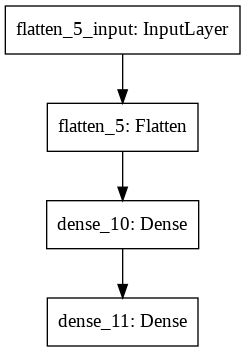

In [10]:
# print a summary for the NN's model
print(model.summary())
# show a figure of the NN
plot_model(model, to_file='model.png')

# Test 3: Compiling the model

The NN model must be compiled next before it is ready for the training phase. This is accomplished by using `model.compile` method in `tf.keras` with three parameters:

`metrics` to specify the metric used to evaluate the model's performance, which in this case corresponds to accuracy using value `acc`. Accuracy is chosen to reflect the percentage of images that are correctly classified. Other choices could be made for `metrics` including the mean square error using value `mse`, or other metrics such as `binary_accuracy`, `categorical_accuracy`, `sparse_categorical_accuracy`, `top_k_categorical_accuracy`, `sparse_top_k_categorical_accuracy`, `cosine_proximity`.

`loss` to measure the model's accuracy between the predicted labels and the true labels during training. This `loss` function is minimized to drive the model towards a local and possibly global optimum. Loss class `SparseCategoricalCrossentropy` is chosen to compute the cross-entropy loss between the true labels and predictions. This loss function is chosen because it is specifically suitable for multi-class problems. The argument `from_logits` indicates whether the predicted label is a [logits](https://developers.google.com/machine-learning/glossary#logits) tensor. Using `from_logits=True` is more numerically stable according to `tf.keras` documentation. Other choices could be made for `loss` including  `BinaryCrossentropy`, `CategoricalCrossentropy`, `CategoricalHinge`, `CosineSimilarity`, `Hinge`, `Huber`, `KLDivergence`, `LogCosh`, `MeanAbsoluteError`, `MeanAbsolutePercentageError`, `MeanSquaredError`, `MeanSquaredLogarithmicError`, `Poisson`, `Reduction`, `SquaredHinge`, and each of these options implements a standard loss function with the same name that evaluates the loss between the predictions and the true labels.

`optimizer` to specify an update policy for the model's parameters based on the loss function values and on the data propagated throughout the NN. Optimizer class `Adam` that implements the Adam algorithm is chosen because this algorithm can handle sparse gradients on noisy data, which is the case in handwritten digits. Other choices could be made for `optimizer` including `Adadelta`, `Adagrad`, `Adamax`, `Ftrl`, `Nadam`, `RMSprop`, `SGD`, and each of these options implements a standard optimization algorithm with the same name, including gradient descent, stochastic optimization, and momentum optimization.

In [0]:
# compile model that compares performance using accuracy as a metric, 
# an optimizer based on the gradient descent algorithm such as adam, and 
# a sparse categorical cross entropy which computes the crossentropy loss 
# between the predictions and true labels, and is specifically designed for 
# multi-class problems. from_logits indicates whether the prediction is a logits tensor.
# Using from_logits=True is more numerically stable according to documentation.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['acc'])

# Test 4: Fitting the model

Fitting the neural network model is performed by feeding the training data `X_train` and training labels `y_train` to the model using `model.fit` method. The number of epochs is specified using argument `epochs` with a value of 10, which was chosen to obtain a good accuracy. The number of epochs indicates how many times the algorithm should repeatedly go through the training data. The model then learns the representations of the training data and adjusts the NN weights accordingly. The training loss and accuracy metrics resulting from training on `X_train` are displayed by the below code.

In [12]:
# number of epochs
n_epochs = 10
# fit the model of the training data/labels
# verbose=1 is chosen to print a progress bar executing the algorithm
# verbose: 0 = silent, 1 = progress bar, 2 = one line per epoch
model.fit(X_train, y_train, epochs=n_epochs, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5697 - acc: 0.9089
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5116 - acc: 0.9502
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4983 - acc: 0.9632
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4911 - acc: 0.9699
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4860 - acc: 0.9745
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4825 - acc: 0.9780
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4801 - acc: 0.9811
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4777 - acc: 0.9826
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4764 - acc: 0.9840
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4750 - acc: 0.9852


# Test 5: Evaluating the model on some test data

### Evaluating the fit of model

The model's accuracy on the testing data is evaluated using `model.evaluate` to which the testing data `X_test` and true labels `y_test` are fed as arguments. The below code shows accuracy as a metric to evaluate how well the model works, and it shows that the NN model attains a very high accuracy on the testing data. The model's linear outputs are in the form of [logits](https://developers.google.com/machine-learning/glossary#logits). A `tf.keras.layers.Softmax` layer is attached to these logits in order to convert them to probabilities of the datapoint belonging to each class, and the datapoint's predicted class is selected as the class with the highest probability among all classes using `np.argmax`, and this class is assigned as the image's predicted label. The model can now make predictions on the testing data `X_test` using `keras.Model.predict` method, and we can then compare the predicted labels to the true labels `y_test`. `keras.Model.predict` returns a list of lists, where each list corresponds to one image in the batch of data. For example, the first datapoint in the testing data is shown to have matching true and predicted label in the below code.

### Experiment using K-fold cross-validation

K-fold cross-validation (CV) is used to test a regression or classification algorithm properly, and consists in splitting the training dataset into K-folds, training on K-1 of them and validating on the remaining fold, and switching the validation fold K times. The resulting mean cv accuracy is a less-biased metric of the performance of the algorithm on the training dataset. To create cross-validation folds, a method from `sklearn` called `sklearn.model_selection.cross_val_score` is used to split the dataset, call the neural network constructor by argument `estimator`, specify the desired number of folds by argument `cv`, specify the training data and labels by arguments `X` and `y`, and finally perform cross-validation. The K-fold cross validation choose a number of folds `cv` equal to 5, which results in an accuracy for each run of the cross validation and a mean accuracy for the total cross validation such as shown by the below code. To build the `estimator` parsed as an argument to `sklearn.model_selection.cross_val_score`, the Keras constructor `KerasClassifier` is called. It takes a building function `build_fn` that indicate how the NN model is to be built and compiled, which was implemented in the `neurnet_classifier()` method below. Since `tf.keras` models are optimized to make predictions on a `batch`, which is collection of datapoints processed by the NN at once, a `batch_size` of value 1000 is chosen; it allows processing the training data of size 60,000 faster by the NN while attaining a very good training accuracy. This experiment used cross validation to vary the parameters on the number of epochs and compare the NN's performance on the training data. The number of epochs was varied from 1 to 20, and the below plots shows that the best cross validation accuracy was achieved with `n_epochs = 20`.

### Experiment using grid search cross-validation
An experiment using grid search cross-validation results to finetune the model's parameters and improve predictions results is run. Using `sklearn.model_selection.GridSearchCV`, several grid search cross validation models are created by generating a model for each tuple of parameters' values specified in list `params`. It  calls the neural network constructor by argument `estimator`, and uses the proposed lists of values for `optimizer`, `number of epochs` and `batch_size`. The scoring metric in this experiment is the mean cv accuracy as specified by argument `scoring`. These models are then fit to the training data using `fit` method, and the best tuple of parameters among all choices is returned by `best_params_` corresponding to the best score returned by `best_score_`. In this manner, the NN model parameters are automatically finetuned and could be fit to changing datasets.

In [13]:
# evaluate the model on the testing data/labels
# verbose=1 is chosen to print a progress bar executing the algorithm
# verbose: 0 = silent, 1 = progress bar, 2 = one line per epoch
_, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Model\'s testing accuracy = {0:.2f}%'.format(test_accuracy * 100))
# generate predicted output using softmax, which selects the class with highest
# probability among all classes and assigns it as the image's predicted label
prediction_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# generate predictions for the testing data
preds = prediction_model.predict(X_test)
# check prediction on a datapoint
print('example datapoint: true label is {0:d} and predicted label is {1:d}'.format(y_test[0], np.argmax(preds[0])))

313/313 [==============================] - 1s 2ms/step - loss: 1.4864 - acc: 0.9754
Model's testing accuracy = 97.54%
example datapoint: true label is 7 and predicted label is 7


In [ ]:
# experiment using K-fold cross-validation results to choose a model parameter
# in the below case to choose an appropriate number of epochs
#
def neurnet_classifier():
    # create model with each input being flattened
    # sequential model is used to indicate the model has a linear stack of layers
    # flatten is used to flatten the 28x28 input to 1x784 input
    # dense layers are used to have fully interconnected neurons, allowing faster learning
    # the number of neurons at the output layer must be equal to the number of classes (10)
    # the relu activation function is chosen for the hidden layer because
    # it avoids the saturation of its gradient, thus accelerating the convergence of 
    # gradient descent compared to other activation functions such as sigmoid / tanh
    # the sigmoid activation function is chosen to smoothen the output to nearest
    # value of either 0 (image not in class) or 1 (image in class)
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
    ])
    # compile model that compares performance using accuracy as a metric, 
    # an optimizer based on the gradient descent algorithm such as adam, and 
    # a sparse categorical cross entropy which computes the crossentropy loss 
    # between the predictions and true labels, and is specifically designed for 
    # multi-class problems. from_logits indicates whether the prediction is a logits tensor.
    # Using from_logits=True is more numerically stable according to documentation.
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['acc'])
    return model
#
# number of datapoints propagated through the NN to train it each time
n_batchsz   = 1000
# number of cross validation folds
n_cvfolds   = 5
# multiple values for parameter: number of epochs
epochs_vals = range(1,21)
# record mean cv accuracy for each parameter: number of epochs
acc_means   = np.empty((len(epochs_vals)))
for i in range(len(epochs_vals)):
    n_epochs     = epochs_vals[i]
    # construct a NN classifier using Keras constructor and calling the building function above
    cf           = KerasClassifier(build_fn=neurnet_classifier, batch_size=n_batchsz, epochs=n_epochs)
    # perform K-fold cross validation on training data/labels to return the list of accuracies
    accuracies   = cross_val_score(estimator=cf, X=X_train, y=y_train, cv=n_cvfolds)
    # cross validation (CV) mean accuracy
    acc_means[i] = accuracies.mean()


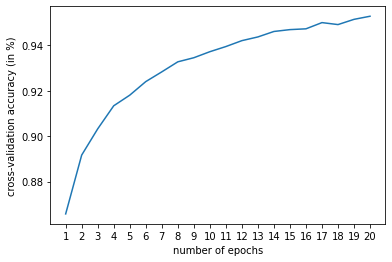

n_epochs = 20 resulted in highest cv accuracy of 95.27%


In [15]:
# after cv is run iteratively on a list of values for a certain parameter, the
# value resulting in highest mean accuracy (i.e. lowest mean error) is chosen
# make a plot of mean cv accuracies vs number of epochs
plt.plot(epochs_vals, acc_means)
plt.xticks(epochs_vals)
plt.xlabel('number of epochs')
plt.ylabel('cross-validation accuracy (in %)')
plt.show()
# best value of n_epochs corresponding to highest cv accuracy (i.e. lowest cv error)
i = int(np.argmax(acc_means))
print('n_epochs = %d resulted in highest cv accuracy of %.2f%%' % 
      (epochs_vals[i],100*acc_means[i]))

In [ ]:
# experiment using grid search cross-validation results to finetune the model's
# parameters and improve predictions results
#
def neurnet_classifier(optimizer):
    # create model with each input being flattened
    # sequential model is used to indicate the model has a linear stack of layers
    # flatten is used to flatten the 28x28 input to 1x784 input
    # dense layers are used to have fully interconnected neurons, allowing faster learning
    # the number of neurons at the output layer must be equal to the number of classes (10)
    # the relu activation function is chosen for the hidden layer because
    # it avoids the saturation of its gradient, thus accelerating the convergence of 
    # gradient descent compared to other activation functions such as sigmoid / tanh
    # the sigmoid activation function is chosen to smoothen the output to nearest
    # value of either 0 (image not in class) or 1 (image in class)
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
    ])
    # compile model that compares performance using accuracy as a metric, 
    # an optimizer based on the gradient descent algorithm such as adam, and 
    # a sparse categorical cross entropy which computes the crossentropy loss 
    # between the predictions and true labels, and is specifically designed for 
    # multi-class problems. from_logits indicates whether the prediction is a logits tensor.
    # Using from_logits=True is more numerically stable according to documentation.
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['acc'])
    return model
#
# construct a NN classifier using Keras constructor and calling the building function above
cf = KerasClassifier(build_fn=neurnet_classifier)
# list of values for multiple parameters in the model to be fed to grid search cv
optimizers = ['adadelta', 'adam', 'rmsprop', 'sgd']
n_epochs   = [10, 20]
n_batchsz  = [1000, 5000]
params     = {
    'optimizer' : optimizers,
    'epochs'    : n_epochs,
    'batch_size': n_batchsz}
# create grid seach cross validation models by generating a model for each tuple of 
# parameters' values specified by params. Scoring metric is the mean cv accuracy
n_cvfolds  = 5
gscv       = GridSearchCV(
    estimator  = cf,
    param_grid = params,
    cv         = n_cvfolds,
    scoring    = 'accuracy'
    )
# fit the set of models to the training data/labels
# verbose=1 is chosen to print a progress bar executing the algorithm
# verbose: 0 = silent, 1 = progress bar, 2 = one line per epoch
gscv       = gscv.fit(X_train, y_train, verbose=1)
# use best_params_ method to return the tuple of parameters that resulted in
# highest mean cv accuracy
best_param = gscv.best_params_
# corresponding mean cv accuracy
best_acc   = gscv.best_score_


In [17]:
# show the best tuples of parameters and the corresponding mean cv accuracy
print('best model parameters:', best_param)
print('with highest cv accuracy: %.2f%%' % (100*best_acc))

best model parameters: {'batch_size': 1000, 'epochs': 20, 'optimizer': 'rmsprop'}
with highest cv accuracy: 95.97%
